# Sentinel-2 Data Handling with **eodal**

## Learning Objectives

In this notebook you will learn how to

* load data from a Sentinel-2 scene organized in the .SAFE folder structure
* calculate some basic vegetation indices (e.g., NDVI) for a region of interest
* get cloudy pixel percentage in a selected area of interest (instead of relying on scene-wide cloud coverage for filtering datasets)
* mask clouds and shadows in an area of interest (AOI)
* plot derived vegetation indices
* visualize the scene classification layer (SCL)
* save the results to a new geoTiff file
* convert bands to `xarray`

## Tutorial Pre-Requisites

This tutorial is introductorial level. You should know, however, about the concept of vegetation indices (VIs). If you do not feel confident about VIs yet, have a look at this [free tutorial by EO4GEO](http://www.eo4geo.eu/training/sentinel-2-data-and-vegetation-indices/).

To run this notebook no additional requirements in terms of software-setup are necessary.

The data required to run this notebook can be found [here](./../data).

In [2]:
# load required modules
import cv2
import numpy as np

from pathlib import Path
from agrisatpy.core.spectral_indices import SpectralIndices
from agrisatpy.core.sensors import Sentinel2

# make plots larger by default
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

### I) Load Data from .SAFE Sentinel-2 dataset in Level-2 Processing Level

`eodal` provides the option to load image data directly from the [.SAFE](https://earth.esa.int/SAFE/) (Standard Archive Format for Europe) and do some basic operations without having to convert the data. This is useful for exploring image data (e.g., quick visualization of datasets) or **fast** calculation of vegetation indices.

We will conduct the following steps:

- Download a sample S2-scene in Level-2, i.e., atmospherically corrected data (no authentication required)
- Dislay the RGB, False-Color Infrared and Scene Classification Layer for a selected Area of Interest (AOI)
- Calculate the Normalized Difference Vegetation Index (NDVI) for the AOI using the 10m Sentinel-2 bands

#### I.1) Download the Data (Not Authentication/Registration required

We created a Mendeley dataset with a sample S2 scene in Level-2 in SAFE dataset structure. The following lines of code will place the dataset in the `../data` directory and unzip it.

**This might take a while depending on your internet connection!**

In [ ]:
# download test data (if not done yet)
import requests
from eodal.downloader.sentinel2.utils import unzip_datasets

# URL to the public dataset
url = 'https://data.mendeley.com/public-files/datasets/ckcxh6jskz/files/e97b9543-b8d8-436e-b967-7e64fe7be62c/file_downloaded'

testdata_dir = Path('../../data')
testdata_fname = testdata_dir.joinpath('S2A_MSIL2A_20190524T101031_N0212_R022_T32UPU_20190524T130304.zip')
testdata_fname_unzipped = Path(testdata_fname.as_posix().replace('.zip', '.SAFE'))

# check first if the dataset has been already downloaded; only start the download if the dataset is not yet available locally
if not testdata_fname_unzipped.exists():

    # download dataset
    r = requests.get(url, stream=True)
    r.raise_for_status()
    with open(testdata_fname, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=5096):
            fd.write(chunk)

    # unzip dataset
    unzip_datasets(download_dir=testdata_dir)

#### I.2) Read the Data from .SAFE

Once the data is downloaded, we can read a selection of bands using `eodal.core.sensors.sentinel2.Sentinel2` that provides a handler for Sentinel-2 data in .SAFE format. We will read the following spectral bands

| S2 Band Name | Color Name | Spatial Resolution [m] |
| ------------ | ---------- | ---------------------- |
| B02          | blue       | 10                     |
| B03          | green      | 10                     |
| B04          | red        | 10                     |
| B05          | red_edge_1 | 20                     |
| B07          | red_edge_3 | 20                     |
| B08          | nir_1      | 10                     |
| SCL          | scl        | 20                     |

B02, B03, B04, and B08 have a native spatial resolution of 10m, whereas B05 and B07 come in 20m spatial resolution. In addition, we also the read the `scene classification layer` (SCL) that comes as an additional layer in Level-2 (Sen2Cor output). The spatial resolution of SCL is also 20m. The SCL layer is read automatically when the processing level is correctly specified as Level-2A.

By default, the handler reads the data which is of data type `unsigned integer 16bit` into floats ranging between 0 and 1 (also the original integer values are scaled between 0 and 100% reflectance). The reason for this is that floats allow for more complex advanced calculations. If, on the other hand, the data is only to be visualised or extracted, it is advisable to retain the 16-bit integer data type. To do this, set `apply_scaling=False` in the `from_safe()` call.

In [3]:
# we can either read all bands are define a subset to read
band_selection = ['B02', 'B03', 'B04', 'B05', 'B07', 'B08']

We will use a AOI covering a subset of the entire S2-scene for which the data is read:

In [5]:
# define file-path to ESRI shapefile (all formats understood by fiona work)
import os

base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent
in_file_aoi = base_dir.joinpath('data/sample_polygons/BY_AOI_2019_MNI_EPSG32632.shp')

# read data from .SAFE dataset for the selected AOI and spectral bands
handler = Sentinel2().from_safe(
    in_dir=testdata_fname_unzipped,
    vector_features=in_file_aoi,
    band_selection=band_selection,
    apply_scaling=False # if True scales the reflectance values between 0 and 1
)
handler

`eodal` maps the spectral bands of Sentinel-2 automatically to color names. Through *band aliasing* it is possible to access spectral bands either through their color name ('blue') **or** through their band name (e.g., 'B02').

In [6]:
# get band names, this will return the color names
handler.band_names

['B02', 'B03', 'B04', 'B05', 'B07', 'B08', 'SCL']

In [7]:
# however, the original band names are still available as aliases
handler.band_aliases

['blue', 'green', 'red', 'red_edge_1', 'red_edge_3', 'nir_1', 'scl']

Thus, you can use the color or band name to access band data:

In [8]:
(handler.get_values(['blue']) == handler.get_values(['B02'])).all()

True

Consequently, single bands can be selected by their color name for **plotting**:

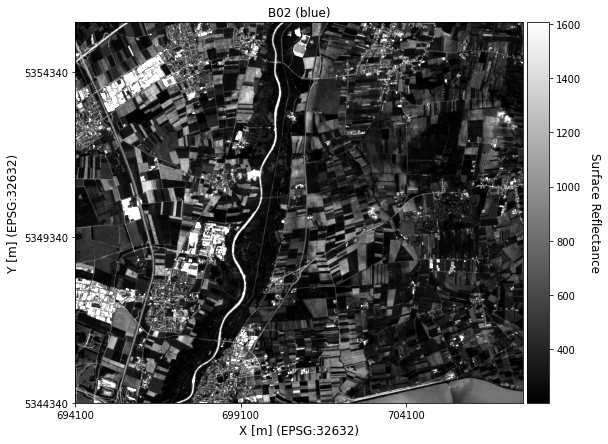

In [16]:
fig_blue = handler.plot_band('blue', colorbar_label='Surface Reflectance')

The handler also automatically extracts some scene-metadata including the image acquisition time, platform and sensor:

In [9]:
handler.scene_properties

{'_acquisition_time': datetime.datetime(2019, 5, 24, 10, 10, 31), '_platform': 'S2A', '_sensor': 'MSI', '_processing_level': <ProcessingLevels.L2A: 'LEVEL2A'>, '_product_uri': 'S2A_MSIL2A_20190524T101031_N0212_R022_T32UPU_20190524T130304.SAFE'}

In [10]:
handler.scene_properties.platform

'S2A'

In [11]:
handler.scene_properties.sensor

'MSI'

In [12]:
handler.scene_properties.processing_level

<ProcessingLevels.L2A: 'LEVEL2A'>

##### Calculate band statistics

`eodal` allows to calculate descriptive statistics of all bands currently loaded or a selection therefor. The results are returned as a `pandas.DataFrame`.

In [17]:
band_stats = handler.band_summaries(band_selection=['B02', 'B03', 'B04', 'B08'])
band_stats

,nanmin,nanmean,nanstd,nanmax,band_name
0,1,528.464341,375.360368,17888,B02
1,1,786.712553,396.316354,16928,B03
2,1,707.325759,529.441083,16280,B04
3,83,3015.172207,1177.780385,15608,B08


The statistical metrics returned by default (min, max, man, std, count) can be overwritten by passing a custom selection of metrics. The metrics must be named like the corresponding ``numpy`` function. To get, for instance, the median and minimum of each band (it is also possible to pass a list of band names to consider) just execute:

In [18]:
band_stats_median = handler.band_summaries(methods=['nanmedian', 'nanmin'])
band_stats_median

,nanmedian,nanmin,band_name
0,405.0,1,B02
1,682.0,1,B03
2,533.0,1,B04
3,1124.0,24,B05
4,3001.0,23,B07
5,3090.0,83,B08
6,4.0,2,SCL


And for a selected subset of bands pass their color *or* Sentinel-2 band names:

##### Exploring the Data - RGB and False-Color NIR Plots

`eodal` allows to quickly visualize band data. Plots work on single bands or on collections thereof, e.g. to plot the three visible bands (RGB  plot):

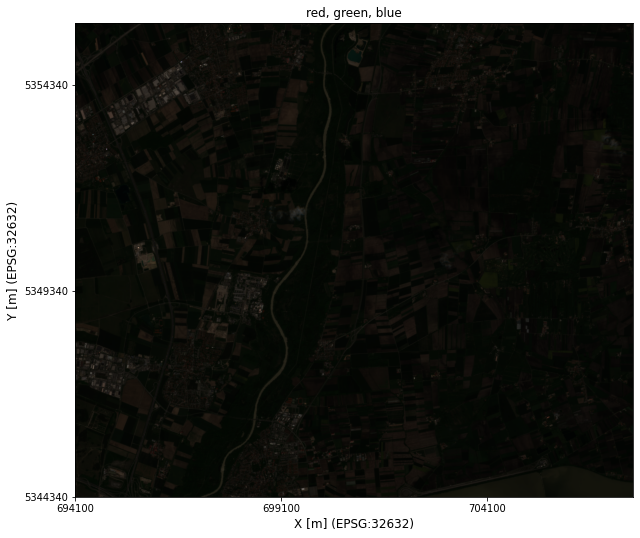

In [19]:
fig_rgb = handler.plot_multiple_bands(['red','green','blue'])

The plot is geo-referenzed, i.e., it shows real (in this case) UTM coordinates on the x and y axis labels.

Another widely used plotting method is the so-called false-color infrared using Sentinel-2 bands B08, B04, and B03 (or: nir_1, red, green):

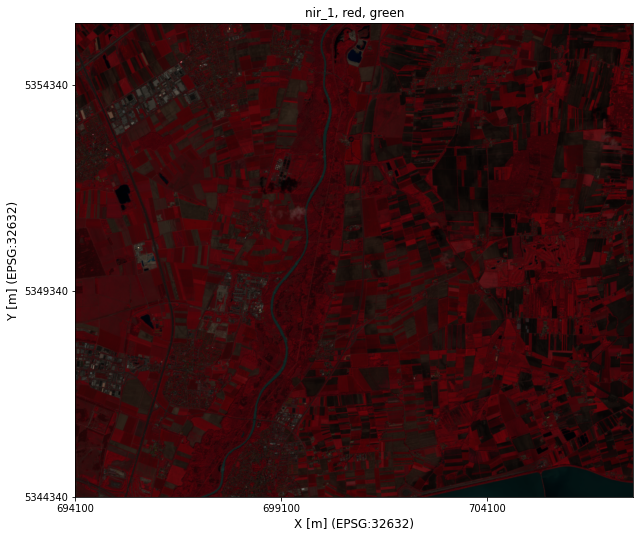

In [20]:
fig_nir = handler.plot_multiple_bands(['nir_1', 'red','green'])

##### Exploring the Data - Scene Classification Layer (SCL)

The SCL layer takes 12 classes and helps to identify clouds, cloud shadows or vegetated areas. The classes have labels between 0 and 11. The official legend can be found [here](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm) (scrawl down).

`eodal`'s Sentinel2Handler is able to plot the SCL following the official color scheme and providing class labels instead of numbers to make interpretation easier:

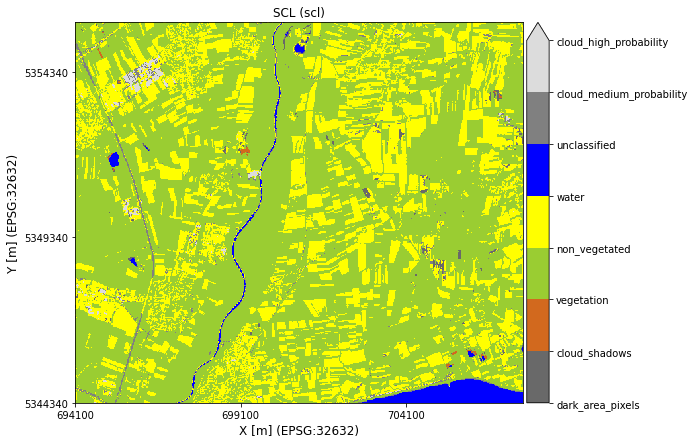

In [21]:
fig_scl = handler.plot_scl()

It is also possible to get the pixel count of all SCL classes as a pandas `DataFrame`:

In [22]:
handler.get_scl_stats()

,Class_Value,Class_Name,Class_Abs_Count,Class_Rel_Count
0,2,dark_area_pixels,1578,0.405369
1,3,cloud_shadows,345,0.088626
2,4,vegetation,260167,66.833729
3,5,non_vegetated,113317,29.109755
4,6,water,6729,1.728598
5,7,unclassified,4966,1.275705
6,8,cloud_medium_probability,962,0.247126
7,9,cloud_high_probability,1211,0.311091
8,0,no_data,0,0.000000
9,1,saturated_or_defective,0,0.000000


#### I.3) Calculate the NDVI

For calculating the NDVI, we only need the 10m bands 'red' and 'nir_1'. `eodal`'s Spectral Index module is designed in a very generic way and automatically selectes the required bands based on their color names (or raises an error if a required band is not found).

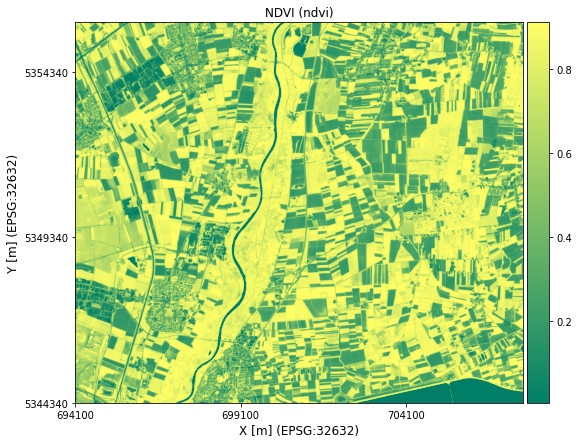

In [23]:
# specify the index name (can be lower or upper case)
vi_name = 'NDVI'

# call the reader's method to calculate indices directly (alternative you can use the SpectralIndices module directly)
handler.calc_si(vi_name, inplace=True)

fig_ndvi = handler.plot_band(band_name=vi_name, colormap='summer')

More spectral indices (currently mostly vegetation indices) are available. You can find the list of currently implemented indices using:

In [25]:
vis = SpectralIndices()
vis.get_si_list()

['BSI',
 'CI_GREEN',
 'EVI',
 'MCARI',
 'MSAVI',
 'MTCARI_OSAVI',
 'NDRE',
 'NDVI',
 'NDWI',
 'NDYI',
 'VARI']

### II) Load Data from .SAFE format and apply Cloud Masking

Often it happens that parts of the AOI are covered by clouds and their shadows. Here, cloud masking comes into play. We show how to use `eodal` and the scene classification layer (SCL) from Sentinel-2 Level-2A data to map clouds in derived image products, such as vegetation indices (see also previous section).

We start with reading the data for a AOI that has some cumulus clouds in it and resample the data - including the SCL layer - to 10m spatial resolution. Then we use the cloud classes in the SCL layer to produce a cloud-masked map of a vegetation index

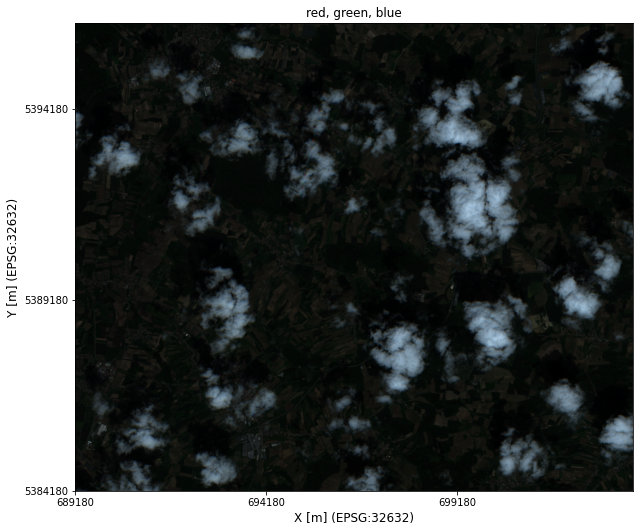

In [26]:
in_file_aoi = Path('../data/sample_polygons/BY_AOI_2019_CLOUDS_EPSG32632.shp')

# get a new reader
handler = Sentinel2().from_safe(
    in_dir=testdata_fname_unzipped,
    vector_features=in_file_aoi,
    band_selection=band_selection
)

# check the RGB
fig_rgb = handler.plot_multiple_bands(['red','green','blue'])

Obviously, this AOI is not cloud-free. This also confirmed by the SCL layer:

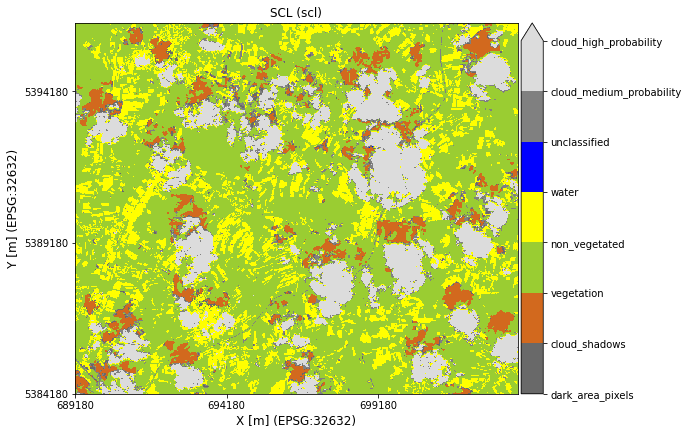

In [27]:
fig_scl = handler.plot_scl()

Using the scene classification we can even quantify the cloud cover and cloud shadow percentage in the selected AOI:

In [28]:
print(f'The cloudy pixel percentage is {np.round(handler.get_cloudy_pixel_percentage(),1)}%')

The cloudy pixel percentage is 26.6%


We resample the data and calculate the MCARI (an index sensitive to leaf chlorophyll content):

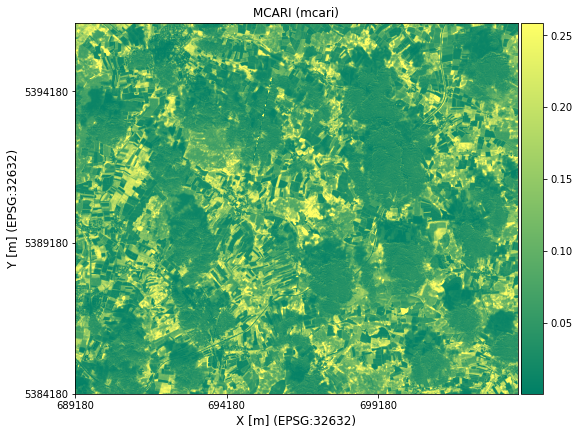

In [29]:
# first resample the spectral bands using bicubic interpolation
handler.resample(
    target_resolution=10,
    interpolation_method=cv2.INTER_NEAREST_EXACT,
    inplace=True
)

# calculate the index and map it (still with clouds)
vi_name = 'MCARI'
handler.calc_si(vi_name, inplace=True)
fig_vi = handler.plot_band(band_name=vi_name, colormap='summer')

With one method call we can mask the clouds and their shadows and set the affected pixels to `np.nan`.

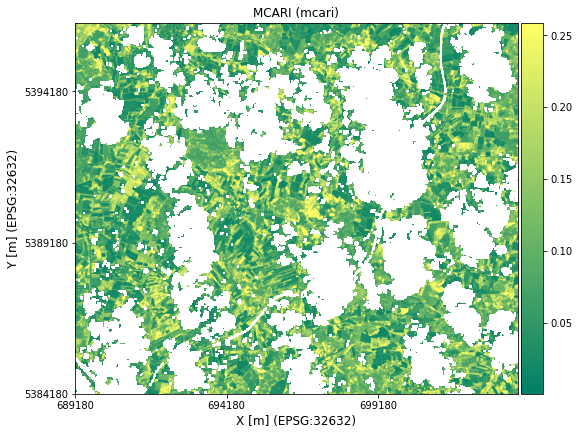

In [30]:
# mask the clouds (SCL classes 8,9,10) and cloud shadows (class 3)
handler.mask_clouds_and_shadows(bands_to_mask=[vi_name])
fig_vi_cloudfree = handler.plot_band(vi_name, colormap='summer')

#### Save raster dataset to file (geoTiff)

After having finished the index calculation AgriSatPy offers the possibility to write the results back into a geo-referenced image using rasterio in the background. Actually every kind of raster format supported by GDAL can be written but we recommend to use geoTiff (the driver seems to be the most stable one).

The driver is recognized by the file name extension; if your file name ends with `*.tif` the writer method will use GDAL's GeoTiff driver for writing:

In [31]:
# set output file name, existing files are overwritten!
fname_ndvi = testdata_dir.joinpath(f'{vi_name}.tif')

# you can write one or more bands as long as they have the same spatial extent and resolution
handler.to_rasterio(
    fpath_raster=fname_ndvi,
    band_selection=[vi_name]
)

#### Convert to xarray

*AgriSatPy* provides an interface to export a handler object to `xarray`. All or a subset of the bands available can be exported - given they have the same spatial extent, pixel size and CRS. If that's not the case, you can use the handler's `resample` and/or `reproject_bands` method.

In [32]:
xds = handler.to_xarray()
xds

<xarray.DataArray (band: 8, y: 1226, x: 1462)>
array([[[0.0448    , 0.048     , 0.0432    , ..., 0.0941    ,
         0.0778    , 0.0628    ],
        [0.0296    , 0.0324    , 0.0334    , ..., 0.1048    ,
         0.1132    , 0.0943    ],
        [0.0377    , 0.0422    , 0.0375    , ..., 0.0968    ,
         0.1282    , 0.124     ],
        ...,
        [0.1104    , 0.1042    , 0.1164    , ..., 0.0563    ,
         0.0549    , 0.0561    ],
        [0.1196    , 0.0938    , 0.1226    , ..., 0.0567    ,
         0.0569    , 0.0583    ],
        [0.1402    , 0.1208    , 0.15      , ..., 0.0577    ,
         0.0568    , 0.0562    ]],

       [[0.0675    , 0.0738    , 0.0708    , ..., 0.1224    ,
         0.1046    , 0.0853    ],
        [0.0577    , 0.0606    , 0.0556    , ..., 0.1282    ,
         0.1348    , 0.1202    ],
        [0.0649    , 0.0717    , 0.0625    , ..., 0.123     ,
         0.1636    , 0.147     ],
...
        [4.        , 4.        , 4.        , ..., 4.        ,
         4.        , 4.        ],
        [4.        , 4.        , 7.        , ..., 4.        ,
         4.        , 4.        ],
        [4.        , 4.        , 7.        , ..., 4.        ,
         4.        , 4.        ]],

       [[0.08160427, 0.07856899, 0.08871615, ..., 0.06032627,
         0.07539837, 0.15536889],
        [0.2110141 , 0.20745414, 0.2305993 , ..., 0.04821365,
         0.01474051, 0.05403727],
        [0.15531138, 0.10114203, 0.12652174, ..., 0.01526496,
         0.01442187, 0.02665138],
        ...,
        [0.01831873, 0.02797378, 0.03576648, ..., 0.04623188,
         0.05585217, 0.05628681],
        [0.02517148, 0.05115754,        nan, ..., 0.05399338,
         0.05530532, 0.05808143],
        [0.04050537, 0.08922062,        nan, ..., 0.05395956,
         0.04791596, 0.05341   ]]])
Coordinates:
  * x        (x) float64 6.892e+05 6.892e+05 6.892e+05 ... 7.038e+05 7.038e+05
  * y        (y) float64 5.396e+06 5.396e+06 5.396e+06 ... 5.384e+06 5.384e+06
  * band     (band) object 'B02' 'B03' 'B04' 'B05' 'B07' 'B08' 'SCL' 'MCARI'
Attributes:
    is_tiled:      1
    nodatavals:    (0, 0, 0, 0, 0, 0, 0, nan)
    scales:        (0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 1, 1.0)
    offsets:       (0, 0, 0, 0, 0, 0, 0, 0.0)
    descriptions:  ('blue', 'green', 'red', 'red_edge_1', 'red_edge_3', 'nir_...
    crs:           32632
    transform:     (10.0, 0.0, 689180.0, 0.0, -10.0, 5396440.0, 0.0, 0.0, 1.0)
    units:         ('', '', '', '', '', '', '', '')